In [2]:
!pip install imbalanced-learn

In [25]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, classification_report
import sklearn.metrics as metrics

In [3]:
#Preparation and cleaning of the data
df = pd.read_csv('data/data.csv', sep=';') #reading dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [4]:
df.y.value_counts()

no     39922
yes     5289
Name: y, dtype: int64

In [5]:
df.columns = df.columns.str.replace(' ', '') #remove white spaces
df = df.rename({'y': 'target'}, axis=1)    #rename the 'y' to 'target' 
print(df.head())  #check the renaming

   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome target  
0  unknown    5   may       261         1     -1         0  unknown     no  
1  unknown    5   may       151         1     -1         0  unknown     no  
2  unknown    5   may        76         1     -1         0  unknown     no  
3  unknown    5   may        92         1     -1         0  unknown     no  
4  unknown    5   may       198         1     -1         0  unknown     no  


In [6]:
print(df.duplicated().value_counts())  #check duplicated values

False    45211
dtype: int64


In [7]:
#Data Quality Report for numeric features
#for train dataset
dqr_cont = df.describe()
cardinality = df.apply(pd.Series.nunique)
dqr_cont.loc['cardinality'] = cardinality[dqr_cont.columns]
dqr_cont.loc['missing'] = df.isnull().sum(axis = 0)
dqr_cont = dqr_cont.T

print(dqr_cont)

            count         mean          std     min    25%    50%     75%  \
age       45211.0    40.936210    10.618762    18.0   33.0   39.0    48.0   
balance   45211.0  1362.272058  3044.765829 -8019.0   72.0  448.0  1428.0   
day       45211.0    15.806419     8.322476     1.0    8.0   16.0    21.0   
duration  45211.0   258.163080   257.527812     0.0  103.0  180.0   319.0   
campaign  45211.0     2.763841     3.098021     1.0    1.0    2.0     3.0   
pdays     45211.0    40.197828   100.128746    -1.0   -1.0   -1.0    -1.0   
previous  45211.0     0.580323     2.303441     0.0    0.0    0.0     0.0   

               max  cardinality  missing  
age           95.0         77.0      0.0  
balance   102127.0       7168.0      0.0  
day           31.0         31.0      0.0  
duration    4918.0       1573.0      0.0  
campaign      63.0         48.0      0.0  
pdays        871.0        559.0      0.0  
previous     275.0         41.0      0.0  


In [8]:
categorical_columns=["job","marital","education","default","housing","loan","contact","month","poutcome","target"]
formatter = "{0:.2f}"
listModeName=[]
list_mode=[]
print(f"{'Feature' : <10}{'Count' : ^10}{'Miss' : ^10}{'Card' : ^10}{'Mode':^10}{'Mode Freq':^15}{'Mode(%)':^15}{'2nd Mode':^15}{'2nd Mode Freq':^15}{'2nd Mode(%)':^15}")
for i in range(len(categorical_columns)):
    listModeName.extend(df[categorical_columns[i]].value_counts().index.tolist())  
    list_mode.extend(df[categorical_columns[i]].value_counts())  
    print(f"{categorical_columns[i].upper(): <10}{df[categorical_columns[i]].count(): ^10}{df[categorical_columns[i]].isnull().sum(): ^10}{df[categorical_columns[i]].nunique(): ^10}{df[categorical_columns[i]].mode().values[0]: ^10}{df[categorical_columns[i]].value_counts().max(): ^15}{formatter.format((df[categorical_columns[i]].value_counts().max()/df[categorical_columns[i]].count())*100): ^15}{listModeName[1]: ^15}{list_mode[1]: ^15}{formatter.format((list_mode[1]/df[categorical_columns[i]].count())*100): ^15}")
    list_mode.clear() 
    listModeName.clear()

Feature     Count      Miss      Card      Mode      Mode Freq       Mode(%)       2nd Mode     2nd Mode Freq   2nd Mode(%)  
JOB         45211       0         12    blue-collar     9732           21.53       management        9458           20.92     
MARITAL     45211       0         3      married       27214          60.19         single          12790          28.29     
EDUCATION   45211       0         4     secondary      23202          51.32        tertiary         13301          29.42     
DEFAULT     45211       0         2         no         44396          98.20           yes            815           1.80      
HOUSING     45211       0         2        yes         25130          55.58           no            20081          44.42     
LOAN        45211       0         2         no         37967          83.98           yes           7244           16.02     
CONTACT     45211       0         3      cellular      29285          64.77         unknown         13020          28

In [9]:
out=[]                  #outlier detection by using IQR method

def iqr_outliers(df):
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    iqr = q3-q1
    Lower_tail = q1 - 1.5 * iqr
    Upper_tail = q3 + 1.5 * iqr
    for i in df:
        if i > Upper_tail or i < Lower_tail:
            out.append(i)
    print("Outliers:", len(out))
          
iqr_outliers(df['previous'])

Outliers: 8257


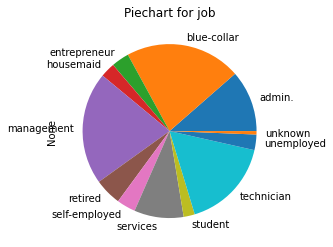

secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: education, dtype: int64


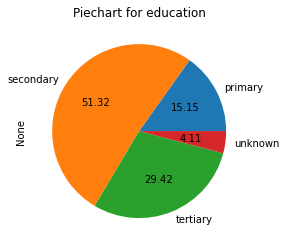

married     27214
single      12790
divorced     5207
Name: marital, dtype: int64


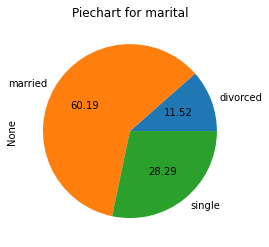

yes    25130
no     20081
Name: housing, dtype: int64


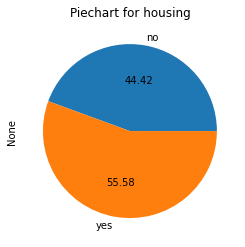

no     44396
yes      815
Name: default, dtype: int64


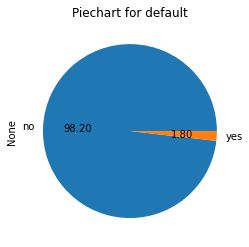

no     37967
yes     7244
Name: loan, dtype: int64


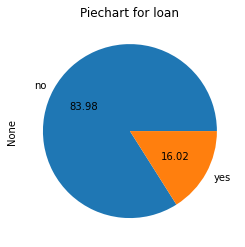

cellular     29285
unknown      13020
telephone     2906
Name: contact, dtype: int64


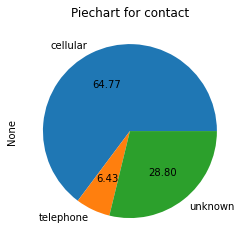

unknown    36959
failure     4901
other       1840
success     1511
Name: poutcome, dtype: int64


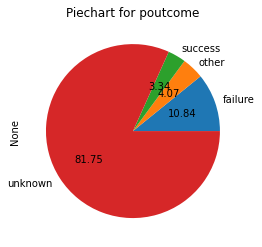

no     39922
yes     5289
Name: target, dtype: int64


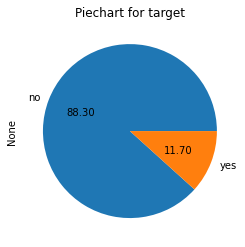

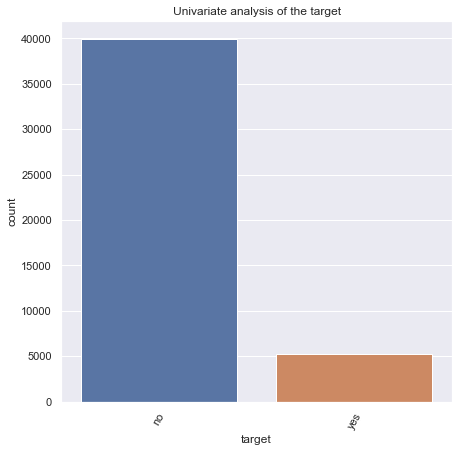

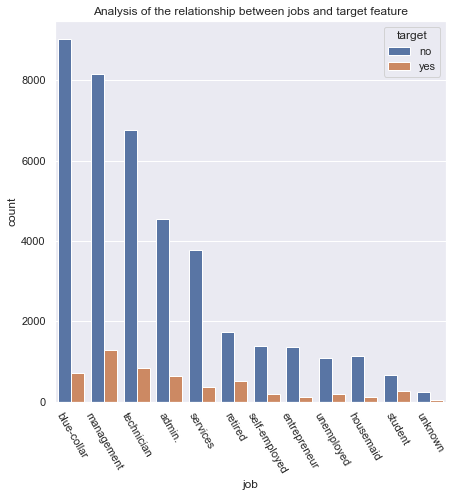

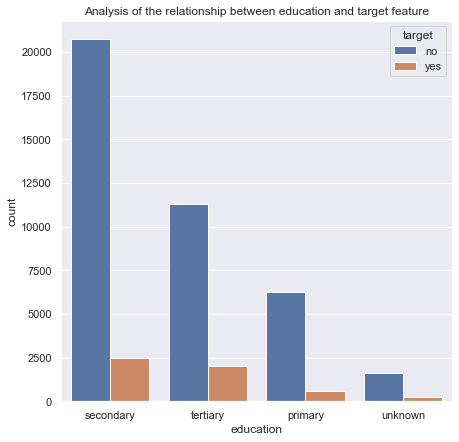

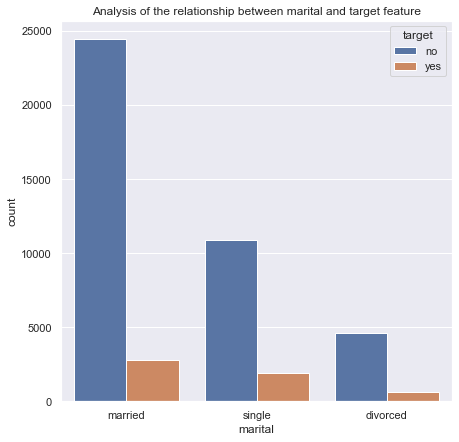

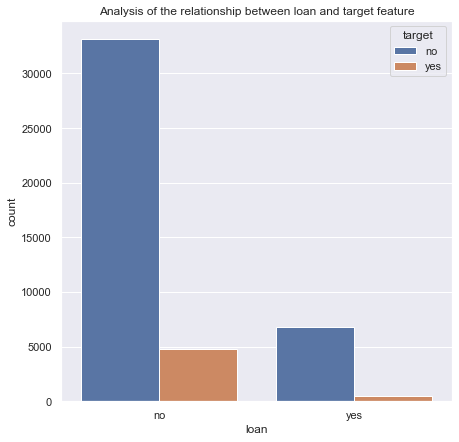

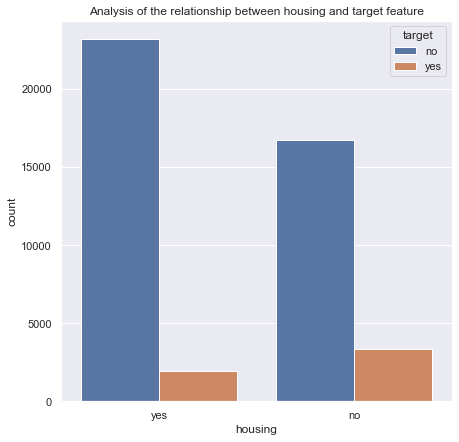

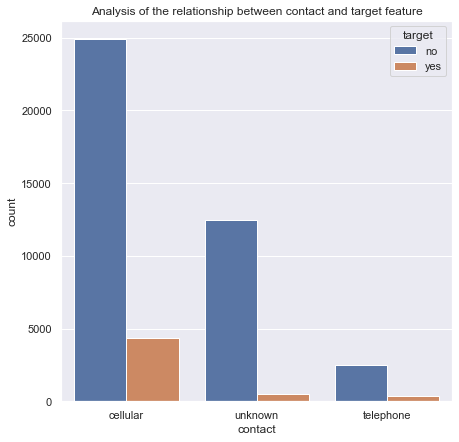

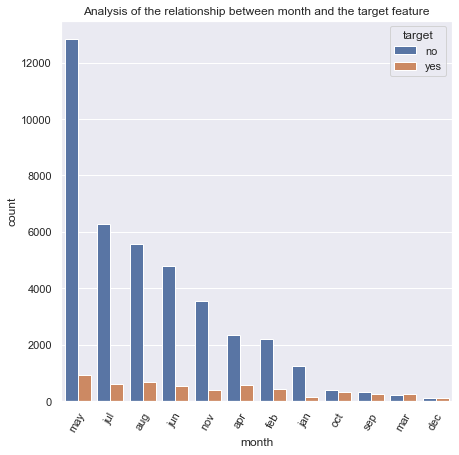

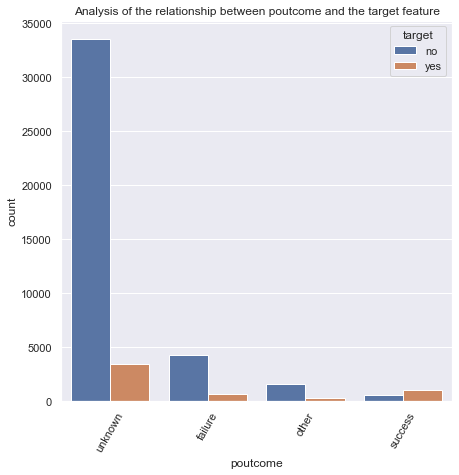

Text(0, 0.5, 'Count')

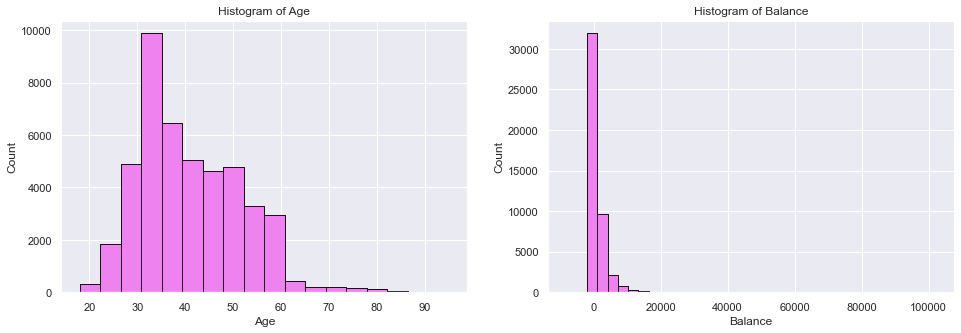

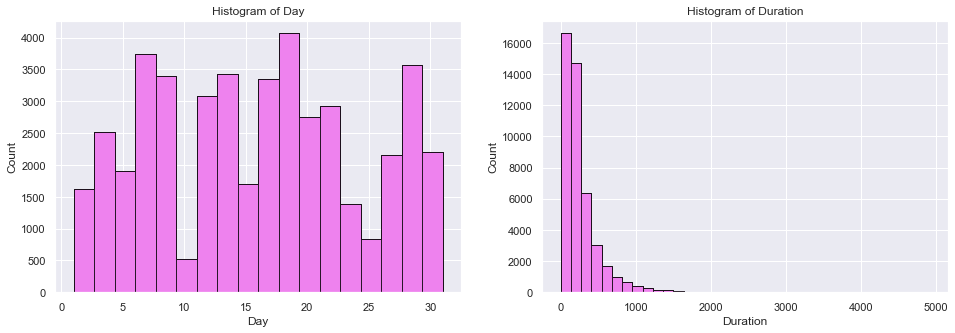

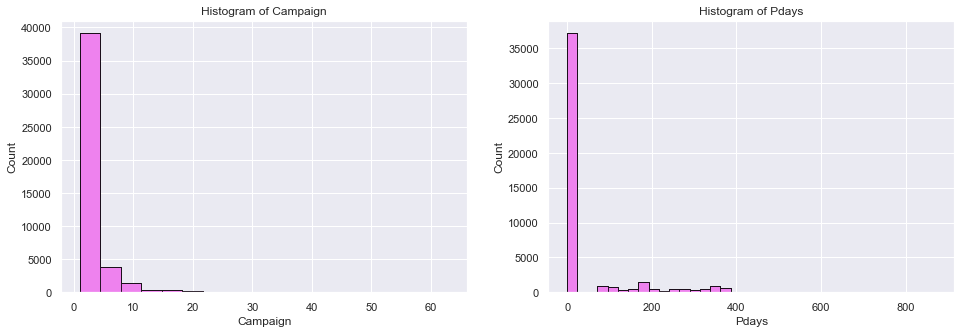

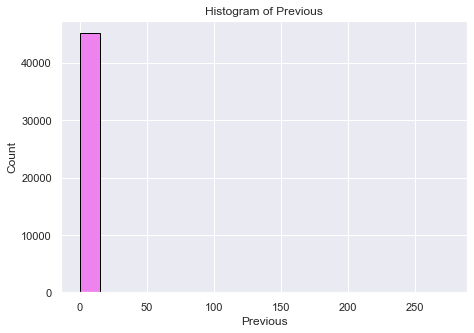

In [10]:
#Data visualization, examining relationship between features

df.groupby('job').size().plot(kind='pie', autopct='')
plt.title('Piechart for job')
plt.show()


print(df["education"].value_counts())
df.groupby('education').size().plot(kind='pie', autopct='%.2f')
plt.title('Piechart for education')
plt.show()

print(df["marital"].value_counts())
df.groupby('marital').size().plot(kind='pie', autopct='%.2f')
plt.title('Piechart for marital')
plt.show()

print(df["housing"].value_counts())
df.groupby('housing').size().plot(kind='pie', autopct='%.2f')
plt.title('Piechart for housing')
plt.show()

print(df["default"].value_counts())
df.groupby('default').size().plot(kind='pie', autopct='%.2f')
plt.title('Piechart for default')
plt.show()

print(df["loan"].value_counts())
df.groupby('loan').size().plot(kind='pie', autopct='%.2f')
plt.title('Piechart for loan')
plt.show()

print(df["contact"].value_counts())
df.groupby('contact').size().plot(kind='pie', autopct='%.2f')
plt.title('Piechart for contact')
plt.show()

print(df["poutcome"].value_counts())
df.groupby('poutcome').size().plot(kind='pie', autopct='%.2f')
plt.title('Piechart for poutcome')
plt.show()

print(df["target"].value_counts())
df.groupby('target').size().plot(kind='pie', autopct='%.2f')
plt.title('Piechart for target')
plt.show()

sns.set_theme(style='darkgrid')
sns.set(rc = {'figure.figsize':(7, 7)})
target = sns.countplot(x="target", data = df, order = df["target"].value_counts().index)
target.tick_params(axis='x', rotation=60)
plt.title("Univariate analysis of the target")
plt.show()

sns.set_theme(style='darkgrid')
sns.set(rc = {'figure.figsize':(7, 7)})
marital = sns.countplot(x="job", data = df, hue = "target", order = df["job"].value_counts().index)
marital.tick_params(axis='x', rotation=300)
plt.title("Analysis of the relationship between jobs and target feature")
plt.show()

sns.set_theme(style='darkgrid')
sns.set(rc = {'figure.figsize':(7, 7)})
marital = sns.countplot(x="education", data = df, hue = "target", order = df["education"].value_counts().index)
marital.tick_params(axis='x')
plt.title("Analysis of the relationship between education and target feature")
plt.show()

sns.set_theme(style='darkgrid')
sns.set(rc = {'figure.figsize':(7, 7)})
marital = sns.countplot(x="marital", data = df, hue = "target", order = df["marital"].value_counts().index)
marital.tick_params(axis='x')
plt.title("Analysis of the relationship between marital and target feature")
plt.show()

sns.set_theme(style='darkgrid')
sns.set(rc = {'figure.figsize':(7, 7)})
sns.countplot(data = df, x="loan", hue ="target")
plt.title("Analysis of the relationship between loan and target feature")
plt.show()

sns.set_theme(style='darkgrid')
sns.set(rc = {'figure.figsize':(7, 7)})
sns.countplot(x="housing", data = df, hue ="target")
plt.title("Analysis of the relationship between housing and target feature")
plt.show()

sns.set_theme(style='darkgrid')
sns.set(rc = {'figure.figsize':(7, 7)})
sns.countplot(x="contact", data = df, hue ="target", order = df["contact"].value_counts().index)
plt.title("Analysis of the relationship between contact and target feature")
plt.show()

sns.set_theme(style='darkgrid')
sns.set(rc = {'figure.figsize':(7, 7)})
month = sns.countplot(x="month", data = df, hue = "target", order = df["month"].value_counts().index)
month.tick_params(axis='x', rotation=60)
plt.title("Analysis of the relationship between month and the target feature")
plt.show()

sns.set_theme(style='darkgrid')
sns.set(rc = {'figure.figsize':(7, 7)})
poutcome = sns.countplot(x="poutcome", data = df, hue = "target", order = df["poutcome"].value_counts().index)
poutcome.tick_params(axis='x', rotation=60)
plt.title("Analysis of the relationship between poutcome and the target feature")
plt.show()

#histograms
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.hist(df['age'], color = 'violet', edgecolor = 'black',
         bins = int(180/10))

# seaborn histogram
sns.distplot(df['age'], hist=True, kde=False, 
             bins=int(180/10), color = 'violet',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Count')

plt.subplot(1,2,2)
plt.hist(df['balance'], color = 'violet', edgecolor = 'black',
         bins = int(180/5))

# seaborn histogram
sns.distplot(df['balance'], hist=True, kde=False, 
             bins=int(180/5), color = 'violet',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of Balance')
plt.xlabel('Balance')
plt.ylabel('Count')

plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.hist(df['day'], color = 'violet', edgecolor = 'black',
         bins = int(180/10))

# seaborn histogram
sns.distplot(df['day'], hist=True, kde=False, 
             bins=int(180/10), color = 'violet',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of Day')
plt.xlabel('Day')
plt.ylabel('Count')

plt.subplot(1,2,2)
plt.hist(df['duration'], color = 'violet', edgecolor = 'black',
         bins = int(180/5))

# seaborn histogram
sns.distplot(df['duration'], hist=True, kde=False, 
             bins=int(180/5), color = 'violet',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of Duration')
plt.xlabel('Duration')
plt.ylabel('Count')

plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.hist(df['campaign'], color = 'violet', edgecolor = 'black',
         bins = int(180/10))

# seaborn histogram
sns.distplot(df['campaign'], hist=True, kde=False, 
             bins=int(180/10), color = 'violet',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of Campaign')
plt.xlabel('Campaign')
plt.ylabel('Count')

plt.subplot(1,2,2)
plt.hist(df['pdays'], color = 'violet', edgecolor = 'black',
         bins = int(180/5))

# seaborn histogram

sns.distplot(df['pdays'], hist=True, kde=False, 
             bins=int(180/5), color = 'violet',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of Pdays')
plt.xlabel('Pdays')
plt.ylabel('Count')

plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.hist(df['previous'], color = 'violet', edgecolor = 'black',
         bins = 18)

# Add labels
plt.title('Histogram of Previous')
plt.xlabel('Previous')
plt.ylabel('Count')

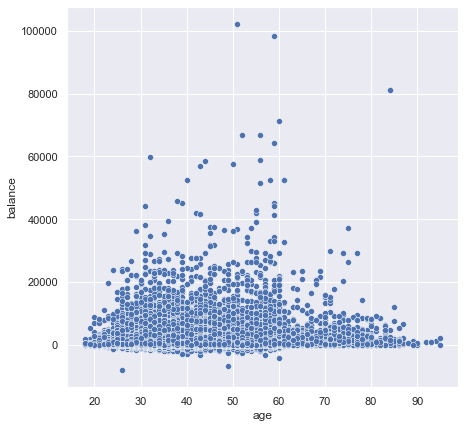

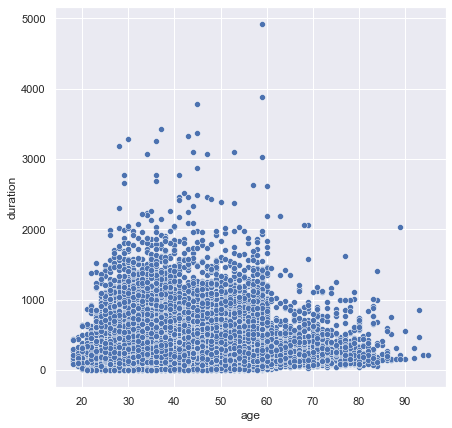

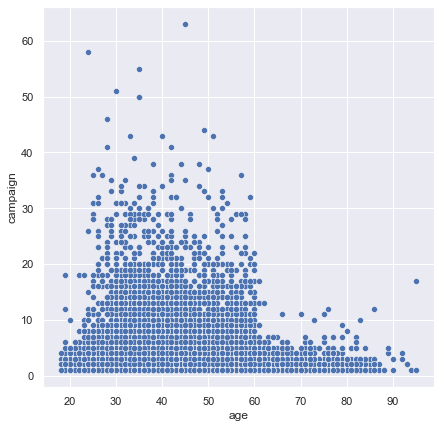

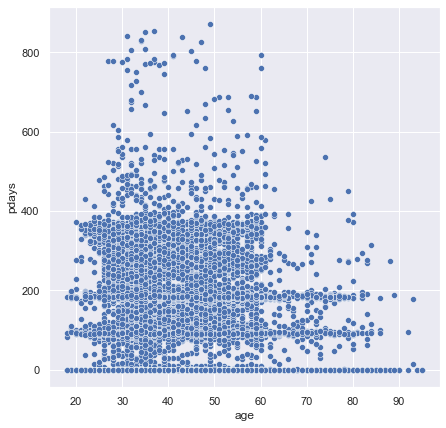

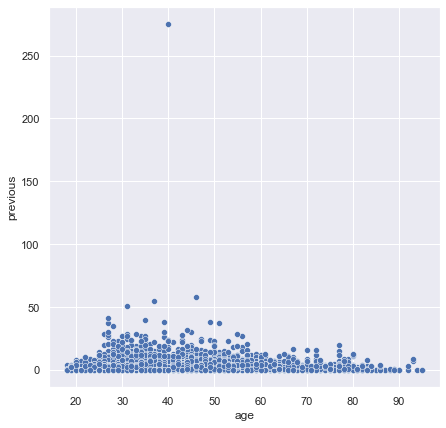

In [11]:
num_cols = ['balance', 'duration', 'campaign', 'pdays', 'previous']  #outlier detection by using visualization
for i in num_cols:
    plt.figure(i)
    sns.scatterplot(data=df, x=df['age'], y=i)

In [12]:
df= df[df['duration'] < 4000]  #outlier handling
df= df[df['previous'] < 100]
df= df[df['campaign'] < 50]
df= df[df['pdays'] < 600]
df= df[df['balance'] < 80000]

In [13]:
df.info()                     

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45147 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45147 non-null  int64 
 1   job        45147 non-null  object
 2   marital    45147 non-null  object
 3   education  45147 non-null  object
 4   default    45147 non-null  object
 5   balance    45147 non-null  int64 
 6   housing    45147 non-null  object
 7   loan       45147 non-null  object
 8   contact    45147 non-null  object
 9   day        45147 non-null  int64 
 10  month      45147 non-null  object
 11  duration   45147 non-null  int64 
 12  campaign   45147 non-null  int64 
 13  pdays      45147 non-null  int64 
 14  previous   45147 non-null  int64 
 15  poutcome   45147 non-null  object
 16  target     45147 non-null  object
dtypes: int64(7), object(10)
memory usage: 6.2+ MB


In [14]:
df.job.value_counts()

blue-collar      9718
management       9434
technician       7586
admin.           5165
services         4153
retired          2261
self-employed    1579
entrepreneur     1487
unemployed       1300
housemaid        1239
student           938
unknown           287
Name: job, dtype: int64

In [15]:
#get ratio between job and education
education_ratio = pd.DataFrame({'Job' : []})
for i in df["job"].unique():
    education_ratio = education_ratio.append(df[(df["job"] == i)]["education"].value_counts().to_frame().iloc[0] * 100 / df[(df["job"] == i)]["education"].value_counts().sum())
education_ratio["Job"] = df["job"].unique()

print(education_ratio)

                     Job  education
tertiary      management  82.446470
secondary     technician  68.810968
tertiary    entrepreneur  46.133154
secondary    blue-collar  55.165672
unknown          unknown  43.902439
secondary        retired  43.387881
secondary         admin.  81.587609
secondary       services  83.241031
tertiary   self-employed  52.754908
secondary     unemployed  55.846154
primary        housemaid  50.605327
secondary        student  54.157783


In [16]:
#replace the unknown values
df.loc[(df.job == "unknown") & (df.education == "secondary"),"job"] = "services"
df.loc[(df.job == "unknown") & (df.education == "primary"),"job"] = "housemaid"
df.loc[(df.job == "unknown") & (df.education == "tertiary"),"job"] = "management"
df.loc[(df.job == "unknown"),"job"] = "blue-collar"

df.loc[(df.education == "unknown") & (df.job == "admin."),"education"] = "secondary"
df.loc[(df.education == "unknown") & (df.job == "management"),"education"] = "secondary"
df.loc[(df.education == "unknown") & (df.job == "services"),"education"] = "tertiary"
df.loc[(df.education == "unknown") & (df.job == "technician."),"education"] = "secondary"
df.loc[(df.education == "unknown") & (df.job == "retired"),"education"] = "secondary"
df.loc[(df.education == "unknown") & (df.job == "blue-collar"),"education"] = "secondary"
df.loc[(df.education == "unknown") & (df.job == "housemaid."),"education"] = "primary"
df.loc[(df.education == "unknown") & (df.job == "self-employed"),"education"] = "tertiary"
df.loc[(df.education == "unknown") & (df.job == "student"),"education"] = "secondary"
df.loc[(df.education == "unknown") & (df.job == "entrepreneur"),"education"] = "tertiary"
df.loc[(df.education == "unknown") & (df.job == "unemployed"),"education"] = "secondary"

df.loc[(df.education == "unknown"),"education"] = "secondary"

df["contact"].replace(["unknown"],df["contact"].mode(),inplace = True)

In [17]:
df.education.value_counts()
df.marital.value_counts()

married     27171
single      12776
divorced     5200
Name: marital, dtype: int64

In [18]:
df = pd.get_dummies(df, columns=['job', 'marital', 'education', 'poutcome'])  #encoding

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45147 entries, 0 to 45210
Data columns (total 34 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   age                  45147 non-null  int64 
 1   default              45147 non-null  object
 2   balance              45147 non-null  int64 
 3   housing              45147 non-null  object
 4   loan                 45147 non-null  object
 5   contact              45147 non-null  object
 6   day                  45147 non-null  int64 
 7   month                45147 non-null  object
 8   duration             45147 non-null  int64 
 9   campaign             45147 non-null  int64 
 10  pdays                45147 non-null  int64 
 11  previous             45147 non-null  int64 
 12  target               45147 non-null  object
 13  job_admin.           45147 non-null  uint8 
 14  job_blue-collar      45147 non-null  uint8 
 15  job_entrepreneur     45147 non-null  uint8 
 16  job_

In [20]:
#encoding the features that have 2 values
binary_cols = ['housing', 'default', 'loan', 'contact', 'target'] 

for i in binary_cols: 
    df[i].replace({'no': 0, 'yes': 1, 'telephone': 0, 'cellular': 1}, inplace=True) 

#df.info()

In [21]:
#drop unrelated feautes
df.drop(columns = ["day","month"],inplace = True) 

In [22]:
scaler = MinMaxScaler(feature_range=(0, 1), copy=True)  #max min normalization [0,1]
scaler.fit(df)
df = pd.DataFrame(scaler.transform(df), index=df.index, columns=df.columns)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45147 entries, 0 to 45210
Data columns (total 32 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  45147 non-null  float64
 1   default              45147 non-null  float64
 2   balance              45147 non-null  float64
 3   housing              45147 non-null  float64
 4   loan                 45147 non-null  float64
 5   contact              45147 non-null  float64
 6   duration             45147 non-null  float64
 7   campaign             45147 non-null  float64
 8   pdays                45147 non-null  float64
 9   previous             45147 non-null  float64
 10  target               45147 non-null  float64
 11  job_admin.           45147 non-null  float64
 12  job_blue-collar      45147 non-null  float64
 13  job_entrepreneur     45147 non-null  float64
 14  job_housemaid        45147 non-null  float64
 15  job_management       45147 non-null 

<AxesSubplot:>

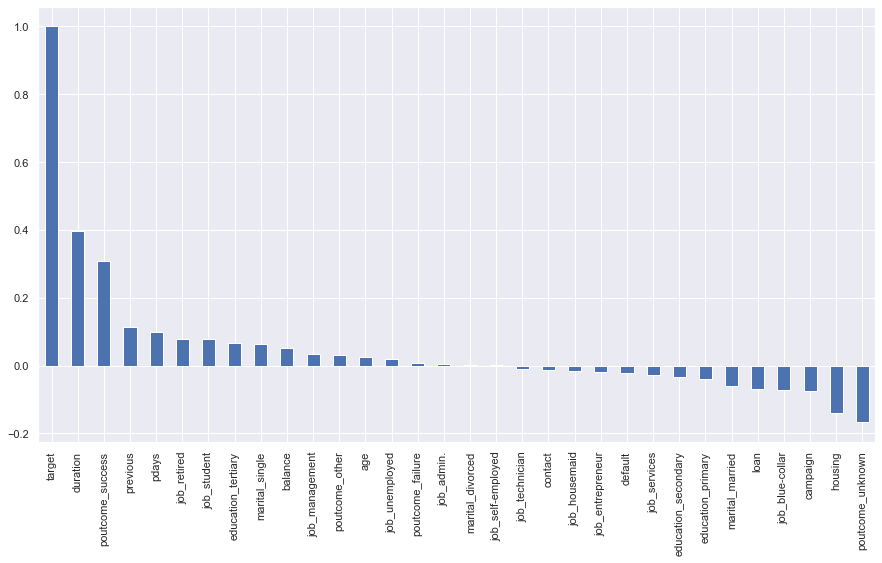

In [23]:
plt.figure(figsize=(15,8))
df.corr()['target'].sort_values(ascending = False).plot(kind='bar') #Correlation of "target" with other features:

In [26]:
y = df.target.to_frame()  #25/75 testing
X = df.drop(columns = ["target"])
X_train , X_test , y_train , y_test = train_test_split(X,y, test_size = 0.25, random_state = 10)

In [27]:
models = [LogisticRegression(solver='liblinear'), #models to be trained
          KNeighborsClassifier(),
          SGDClassifier(),
          DecisionTreeClassifier(),
          RandomForestClassifier(),
          SVC()
        ]

In [28]:
for i, model in enumerate(models):        #25/75 and 10-fold training
    model.fit(X_train, y_train)
    print(models[i], ':', model.score(X_test, y_test))
    y_pred = model.predict(X_test)
    conf_mat = confusion_matrix(y_test, y_pred)
    #acc = accuracy_score(y_test, y_pred)
    print("Confusion Matrix : ")
    print(conf_mat)
    print(classification_report(y_test, y_pred))
    print('Cross Validation mean:',(cross_val_score(model, X_train, y_train, cv=10, n_jobs=2, scoring = 'accuracy').mean()))
    print()

LogisticRegression(solver='liblinear') : 0.8967839106937184
Confusion Matrix : 
[[9755  223]
 [ 942  367]]
              precision    recall  f1-score   support

         0.0       0.91      0.98      0.94      9978
         1.0       0.62      0.28      0.39      1309

    accuracy                           0.90     11287
   macro avg       0.77      0.63      0.67     11287
weighted avg       0.88      0.90      0.88     11287

Cross Validation mean: 0.900915534554046

KNeighborsClassifier() : 0.8859750155045628
Confusion Matrix : 
[[9647  331]
 [ 956  353]]
              precision    recall  f1-score   support

         0.0       0.91      0.97      0.94      9978
         1.0       0.52      0.27      0.35      1309

    accuracy                           0.89     11287
   macro avg       0.71      0.62      0.65     11287
weighted avg       0.86      0.89      0.87     11287

Cross Validation mean: 0.8904607206142942

SGDClassifier() : 0.8933286081332507
Confusion Matrix : 
[[9831

In [29]:
sm = SMOTE() #oversampling
X_sm , y_sm = sm.fit_resample(X, y)
y_sm.target.value_counts()

0.0    39879
1.0    39879
Name: target, dtype: int64

LogisticRegression(solver='liblinear') : 0.8198595787362086
Confusion Matrix : 
[[8412 1618]
 [1974 7936]]
              precision    recall  f1-score   support

         0.0       0.81      0.84      0.82     10030
         1.0       0.83      0.80      0.82      9910

    accuracy                           0.82     19940
   macro avg       0.82      0.82      0.82     19940
weighted avg       0.82      0.82      0.82     19940

Cross Validation mean: 0.8182317978848769

R2 Score:  0.27941221743447764
Mean Absolute Error:  0.18014042126379137
Mean Squared Error 0.18014042126379137


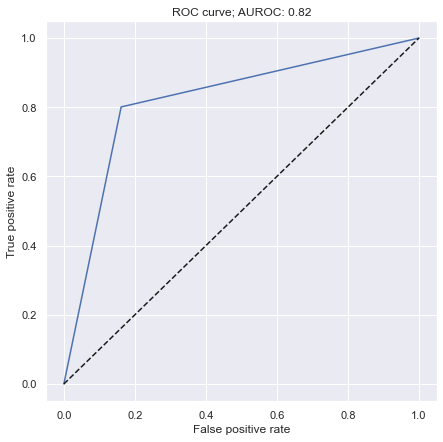

KNeighborsClassifier() : 0.8801905717151455
Confusion Matrix : 
[[8169 1861]
 [ 528 9382]]
              precision    recall  f1-score   support

         0.0       0.94      0.81      0.87     10030
         1.0       0.83      0.95      0.89      9910

    accuracy                           0.88     19940
   macro avg       0.89      0.88      0.88     19940
weighted avg       0.89      0.88      0.88     19940

Cross Validation mean: 0.8733826598225262

R2 Score:  0.5207449296912492
Mean Absolute Error:  0.11980942828485457
Mean Squared Error 0.11980942828485457


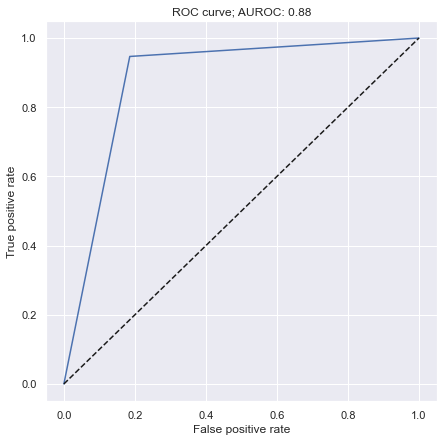

SGDClassifier() : 0.8138415245737212
Confusion Matrix : 
[[8497 1533]
 [2179 7731]]
              precision    recall  f1-score   support

         0.0       0.80      0.85      0.82     10030
         1.0       0.83      0.78      0.81      9910

    accuracy                           0.81     19940
   macro avg       0.82      0.81      0.81     19940
weighted avg       0.82      0.81      0.81     19940

Cross Validation mean: 0.8099896440142474

R2 Score:  0.2553391289300615
Mean Absolute Error:  0.18615847542627884
Mean Squared Error 0.18615847542627884


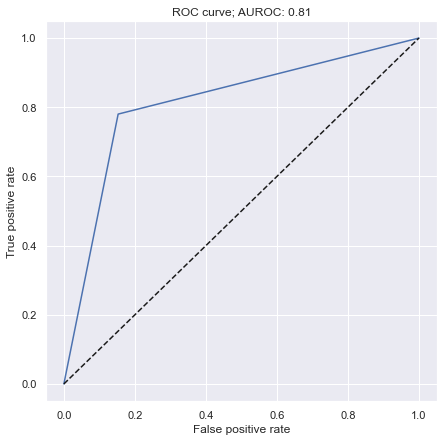

DecisionTreeClassifier() : 0.8796890672016048
Confusion Matrix : 
[[8721 1309]
 [1090 8820]]
              precision    recall  f1-score   support

         0.0       0.89      0.87      0.88     10030
         1.0       0.87      0.89      0.88      9910

    accuracy                           0.88     19940
   macro avg       0.88      0.88      0.88     19940
weighted avg       0.88      0.88      0.88     19940

Cross Validation mean: 0.8764919319067385

R2 Score:  0.5187388389825478
Mean Absolute Error:  0.12031093279839518
Mean Squared Error 0.12031093279839518


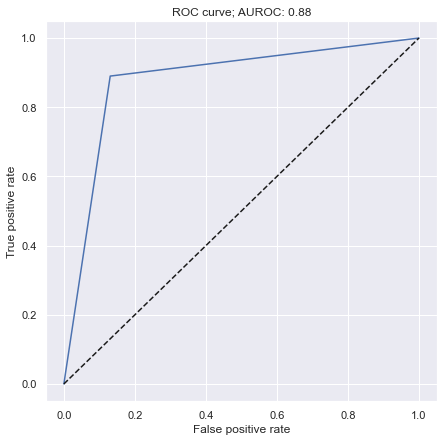

RandomForestClassifier() : 0.927432296890672
Confusion Matrix : 
[[9079  951]
 [ 496 9414]]
              precision    recall  f1-score   support

         0.0       0.95      0.91      0.93     10030
         1.0       0.91      0.95      0.93      9910

    accuracy                           0.93     19940
   macro avg       0.93      0.93      0.93     19940
weighted avg       0.93      0.93      0.93     19940

Cross Validation mean: 0.9246213561265639

R2 Score:  0.7097186744509156
Mean Absolute Error:  0.07256770310932799
Mean Squared Error 0.07256770310932799


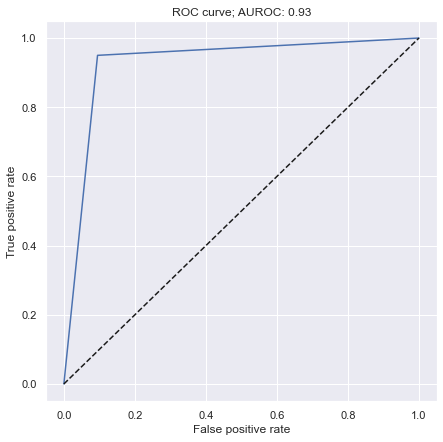

SVC() : 0.8367101303911735
Confusion Matrix : 
[[8428 1602]
 [1654 8256]]
              precision    recall  f1-score   support

         0.0       0.84      0.84      0.84     10030
         1.0       0.84      0.83      0.84      9910

    accuracy                           0.84     19940
   macro avg       0.84      0.84      0.84     19940
weighted avg       0.84      0.84      0.84     19940

Cross Validation mean: 0.8338124500011768

R2 Score:  0.34681686524684274
Mean Absolute Error:  0.16328986960882647
Mean Squared Error 0.16328986960882647


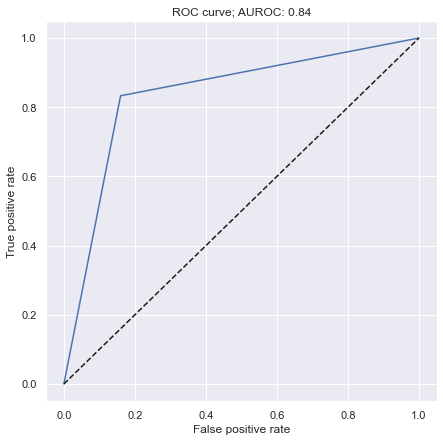

In [30]:
X_train_sm , X_test_sm , y_train_sm , y_test_sm = train_test_split(X_sm, y_sm, test_size = 0.25, random_state = 10)
  #same process with before on the oversampled dataset
for i, model in enumerate(models):
    model.fit(X_train_sm, y_train_sm)
    print(models[i], ':', model.score(X_test_sm, y_test_sm))
    y_pred_sm = model.predict(X_test_sm)
    conf_mat = confusion_matrix(y_test_sm, y_pred_sm)
    #acc = accuracy_score(y_test, y_pred)
    print("Confusion Matrix : ")
    print(conf_mat)
    print(classification_report(y_test_sm, y_pred_sm))
    print('Cross Validation mean:',(cross_val_score(model, X_train_sm, y_train_sm, cv=10, n_jobs=2, scoring = 'accuracy').mean()))
    print()
    from sklearn.metrics import r2_score
    r2score = r2_score(y_test_sm, y_pred_sm)
    print('R2 Score: ', r2score)
    from sklearn.metrics import mean_absolute_error
    mae = mean_absolute_error(y_test_sm, y_pred_sm)
    print('Mean Absolute Error: ', mae)
    from sklearn.metrics import mean_squared_error
    mse = mean_squared_error(y_test_sm, y_pred_sm)
    print('Mean Squared Error' ,mse)
    from sklearn.metrics import roc_curve, roc_auc_score
    fpr, tpr, thresholds = roc_curve(y_test_sm, y_pred_sm)
    sns.set()

    plt.plot(fpr, tpr)

    plt.plot(fpr, fpr, linestyle = '--', color = 'k')

    plt.xlabel('False positive rate')

    plt.ylabel('True positive rate')

    AUROC = np.round(roc_auc_score(y_test_sm, y_pred_sm), 2)

    plt.title(f'ROC curve; AUROC: {AUROC}');

    plt.show()

The most important metric in this project is recall and the variable is 'yes'. Because 'yes' values are the potential customers to subscribe. And, the accuracy of the predicted 'yes' is represented by the recall metric. After the oversampling, recall of the yes values increased and Decision Tree, Random Forest and KNN have the highest recall values. When the other metrics are examined, Random Forest is the best model among the models used.